# Plik roboczy

In [81]:
using Plots
using IJulia
using LinearAlgebra
gr()

Plots.GRBackend()

rungekutta4 - źródło kodu:
https://perso.crans.org/besson/publis/notebooks/Runge-Kutta_methods_for_ODE_integration_in_Julia.html

In [114]:
function rungekutta4(f, y0, t)
    n = length(t)
    y = zeros((n, length(y0)))
    y[1,:] = y0
    hit = nothing
    actual_hit = nothing
    p = nothing
    for i in 1:n-1
        h = t[i+1] - t[i]
        (k1, hit) = f(y[i,:], t[i]; hit = hit)
        if actual_hit != hit
            y[i+1, :] = k1 
        else
            (k2, p) = f(y[i,:] + k1 * h/2, t[i] + h/2; hit = hit)
            (k3, p) = f(y[i,:] + k2 * h/2, t[i] + h/2; hit = hit)
            (k4, p) = f(y[i,:] + k3 * h, t[i] + h; hit = hit)
            y[i+1,:] = y[i,:] + (h/6) * (k1 + 2*k2 + 2*k3 + k4)
        end
        actual_hit = hit
    end
    return y
end

rungekutta4 (generic function with 1 method)

In [97]:
function euler(f, y_0, t)
    n = length(t)
    y = zeros((n, length(y_0)))
    y[1, :] = y_0
    hit = nothing
    actual_hit = nothing
    for i in 1:n-1
        h = t[i + 1] - t[i]
        (k, hit) =  f(y[i, :], t[i]; hit = hit)
        if actual_hit != hit
            y[i + 1, :] = k
        else
            y[i+1, :] = y[i, :] + h * k
        end
        actual_hit = deepcopy(hit)
    end
    return y
end

euler (generic function with 1 method)

## Równania ruchu piłki

https://indico.cern.ch/event/163205/contributions/1413227/attachments/192775/270516/Team351.pdf

$\begin{align}    
    &\text{Siła ciężkości:}  &&F_g = -mg\hat{y} \\
    &\text{Siła wyporu:}  &&F_w = \rho V g \,\hat{y} = B \, \hat{y} \\
    &\text{Siła oporu powietrza:} &&F_o = -\tfrac{1}{2}C_d\rho A v^2 \hat{v} = -bv^2\hat{v} = -b(\dot{x}^2 + \dot{y}^2)^{\frac{1}{2}}(\dot{x}\hat{x} + \dot{y}\hat{y})\\
    &\text{Siła Magnusa:} &&F_M = C_M \rho D^3 \bar{\omega} \times \bar{v} = c \, \bar{\omega} \times \bar{v} = -c \, \omega \dot{y}\hat{x} + c \, \omega \dot{x}\hat{y}\\
\end{align}$

$$ \begin{cases} m\ddot{x} = -b(\dot{x}^2 + \dot{y}^2)^{\frac{1}{2}}\dot{x} - c\,\omega\,\dot{y} \\
m\ddot{y} = -mg + B -b(\dot{x}^2 + \dot{y}^2)^{\frac{1}{2}}\dot{y} + c\,\omega\,\dot{x} \end{cases}$$

In [25]:
r(ball_x::Real, ball_y::Real, rim_x::Real, rim_y::Real) = 
    sqrt((ball_x - rim_x) ^ 2 + (ball_y - rim_y) ^ 2)

r (generic function with 1 method)

In [26]:
ṙ(ball_x::Real, ball_ẋ::Real, ball_y::Real, ball_ẏ::Real, rim_x::Real, rim_y::Real) = 
    (ball_ẋ * (ball_x - rim_x) + ball_ẏ * (ball_y - rim_y)) / r(ball_x, ball_y, rim_x, rim_y)

ṙ (generic function with 1 method)

In [30]:
ϕ(ball_x::Real, ball_y::Real, rim_x::Real, rim_y::Real) = angle(ball_y - rim_y + im * (ball_x - rim_x))

ϕ (generic function with 1 method)

In [32]:
ϕ̇(ball_x::Real, ball_ẋ::Real, ball_y::Real, ball_ẏ::Real, rim_x::Real, rim_y::Real) = 
    (ball_ẋ * (ball_y - rim_y) - ball_ẏ * (ball_x - rim_x)) / (r(ball_x, ball_y, rim_x, rim_y) ^ 2)

ϕ̇ (generic function with 1 method)

In [83]:
is_collision(ball_x::Real, ball_y::Real, ball_radius::Real, rim_x::Real, rim_y::Real, rim_radius::Real) = 
    sqrt((ball_x - rim_x) ^ 2 + (ball_y - rim_y) ^ 2) <= ball_radius + rim_radius

is_collision (generic function with 1 method)

In [20]:
is_approaching(ṙ::Real) = ṙ < 0
is_moving_away(ṙ::Real) = ṙ > 0

is_moving_away (generic function with 1 method)

In [35]:
is_friction(r::Real, rim_x::Real, rim_y::Real, ω::Real, ϕ̇::Real, rim_radius::Real; ϵ::Real = 1e-3) =
    !isapprox(r * ω - ϕ̇ * (r + rim_radius), 0, atol = ϵ)

is_friction (generic function with 3 methods)

In [36]:
function change_to_slipping(ball_x::Real, ball_ẋ::Real, ball_y::Real, ball_ẏ::Real, rim_x::Real, rim_y::Real,
                            ω::Real, ball_radius::Real, rim_radius::Real; ϵ::Real = 1e-3)
    r = r(ball_x, ball_y, rim_x, rim_y)
    ṙ = ṙ(ball_x, ball_ẋ, ball_y, ball_ẏ, rim_x, rim_y)
    ϕ̇ = ϕ̇(ball_x, ball_ẋ, ball_y, ball_ẏ, rim_x, rim_y)
    return is_collision(ball_radius, r; ϵ = ϵ) &&
           is_approaching(ṙ) &&
           is_friction(r, ω, ϕ̇, rim_radius; ϵ = ϵ)
end

change_to_slipping (generic function with 2 methods)

In [39]:
lack_of_normal(k::Real, ball_radius::Real, r::Real, ṙ::Real, c::Real; ϵ::Real = 1e-3) = 
    isapprox(k * (ball_radius - r) - c * ṙ, 0, atol = ϵ)

lack_of_normal (generic function with 1 method)

In [40]:
function change_to_flight(ball_x::Real, ball_ẋ::Real, ball_y::Real, ball_ẏ::Real, rim_x::Real, rim_y::Real,
                          k::Real, ball_radius::Real, c::Real; ϵ::Real = 1e-3)
    r = r(ball_x, ball_y, rim_x, rim_y)
    ṙ = ṙ(ball_x, ball_ẋ, ball_y, ball_ẏ, rim_x, rim_y)
    return lack_of_normal(k, ball_radius, r, ṙ, c; ϵ = ϵ)  && is_moving_away(ṙ)
end

change_to_flight (generic function with 2 methods)

In [84]:
collision_angle(ball_x::Real, ball_y::Real, rim_x::Real, rim_y::Real) = 
    angle(ball_y - rim_y + (ball_x - rim_x)im)

collision_angle (generic function with 1 method)

In [85]:
function rotate_coordinates(x::Real, y::Real, angle::Real; counterclockwise::Bool = true)
    z = counterclockwise ? (x + y * im) * exp(angle * im) : (x + y * im) * exp(-angle * im)
    return z.re, z.im
end

rotate_coordinates (generic function with 1 method)

In [86]:
ẋ_after_collision(ẋ::Real, ω::Real, ball_radius::Real) = 2ẋ / 5 + 3ω * ball_radius / 5

ẋ_after_collision (generic function with 1 method)

In [87]:
angular_velocity(ẋ::Real, ẏ::Real, ball_radius::Real) = norm(ẋ, ẏ) / ball_radius

angular_velocity (generic function with 1 method)

2.23606797749979

In [115]:
# u = [x, x', y, y']
# u' = [x', x'', y', y'']

g = 9.81
m = 0.623
c = 0.00381
B = 0.0784
b = 0.026
ω = 4π

function basketball_throw(u, t; hit = nothing, ball_radius::Real = 0.12, 
                          rim_x_front::Real = 3.36, rim_x_back::Real = 3.96,
                          rim_y::Real = 3.09, rim_radius::Real = 0.04)
    if is_collision(u[1], u[3], ball_radius, rim_x_front, rim_y, rim_radius) && hit != "front"
        global ω
        ẋ, ẏ = rotate_coordinates(u[2], u[4], collision_angle(u[1], u[3], rim_x_front, rim_y))
        ẏ *= -1
        ẋ = ẋ_after_collision(ẋ, ω, ball_radius)
        ω = angular_velocity(ẋ, ẏ, ball_radius)
        ẋ, ẏ = rotate_coordinates(ẋ, ẏ, collision_angle(u[1], u[3], rim_x_front, rim_y); counterclockwise = false)
        return  ([u[1], ẋ,
                u[3], ẏ], "front")
    elseif is_collision(u[1], u[3], ball_radius, rim_x_back, rim_y, rim_radius) && hit != "back"
        global ω
        ẋ, ẏ = rotate_coordinates(u[2], u[4], collision_angle(u[1], u[3], rim_x_back, rim_y))
        ẏ *= -1
        ẋ = ẋ_after_collision(ẋ, ω, ball_radius)
        ω = angular_velocity(ẋ, ẏ, ball_radius)
        ẋ, ẏ = rotate_coordinates(ẋ, ẏ, collision_angle(u[1], u[3], rim_x_back, rim_y); counterclockwise = false)
        return  ([u[1], ẋ,
                u[3], ẏ], "back")
        
    else
        return ([u[2], (- b * sqrt(u[2]^2 + u[4]^2) * u[2] - c * ω * u[4]) / m,
                u[4], (- m * g + B - b * sqrt(u[2]^2 + u[4]^2) * u[4] + c * ω * u[2]) / m], hit)
    end
end

basketball_throw (generic function with 1 method)

$$ \dot{x} = v_0\cos{\theta_0} $$
$$ \dot{y} = v_0\sin{\theta_0} $$

In [10]:
# absolute parameters (given in meters)

three_point_line_x = 7.24
free_throw_line_x  = 3.96
rim_y = 3.05
rim_diameter  = 0.46
ball_diameter = 0.2387
score_error = (rim_diameter - ball_diameter) / 2

# relative parameters (given in meters)

players_height = 1.91;

1.91

In [135]:
v₀ = 8
θ₀ = 40
rθ₀ = θ₀ / 180 * π  # [rad]

x₀ = 0
time = 2 # [seconds]
u₀ = [x₀; v₀ * cos(rθ₀); players_height; v₀ * sin(rθ₀)]
tspan = range(0, stop=time, length=time*60) # [time*60 - miliseconds]
sol = rungekutta4(basketball_throw, u₀, tspan);
#sol = euler(basketball_throw, u₀, tspan)

In [19]:
rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])

function visualize_throw(sol, distance, t)
    
    plot( # trajectory
        sol[1:t,1], 
        sol[1:t,3], 
        xlims=[0,distance + 1], 
        ylims=[0, maximum(sol[:, 3])], 
        linestyle=:dash, 
        legend = :none,
        color=:royalblue1
        )
    
    plot!( # rim
        rectangle(0.6, 0.08,
        distance - 0.6, rim_y), 
        opacity=.7, 
        color= :orangered1
        )
    
    plot!( # pole
        rectangle(0.1, rim_y, distance, 0), 
        opacity=.5, 
        color=:grey
        )
    
    plot!( # net
        Shape([distance - 0.55, distance, distance - 0.2, distance - 0.45], 
                [rim_y, rim_y, rim_y - 0.5, rim_y - 0.5]), 
        color=:white, 
        opacity = .3, 
        aspect_ratio=:equal
        )   
end

visualize_throw (generic function with 1 method)

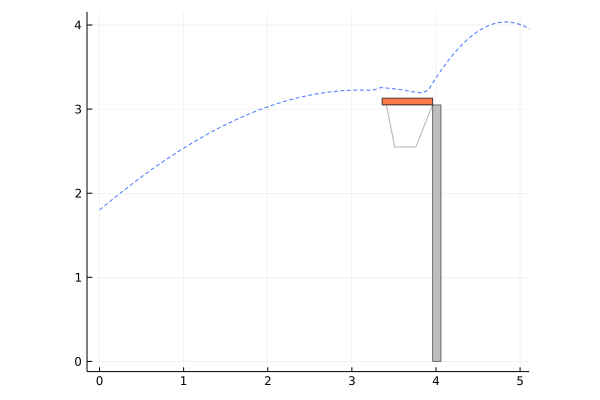

In [136]:
visualize_throw(sol, free_throw_line_x, 120)

In [120]:
function animate_throw(trajektories, distance, t, delay)
    for sol in trajektories
        for i in 1:t
            
            visualize_throw(sol, distance, i)
            
            scatter!( # ball
                [sol[i, 1]], 
                [sol[i, 3]], 
                markersize=10, 
                label="", 
                color=:darkorange1
                ) |> IJulia.display
            
            IJulia.clear_output(true)
            sleep(delay)
        end
    end
end

animate_throw (generic function with 1 method)

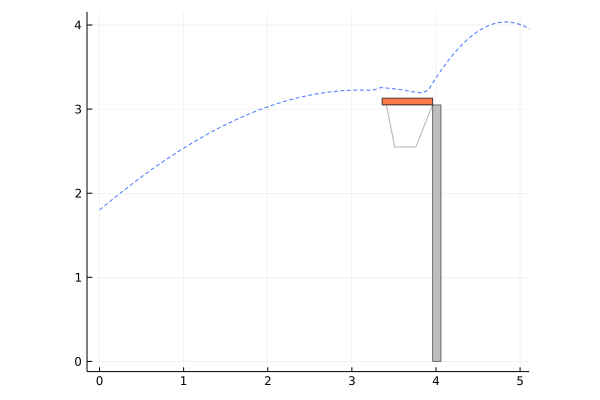

In [138]:
animate_throw([sol], free_throw_line_x, 120, 0)

## Szukanie wartości początkowych v₀ i θ₀ dla których rzut jest celny - symulacja

Rzut celny: 

współrzędna y piłki ~= współrzędna y środka obręczy piłki

oraz

współrzędna x piłki ± margines błędu = współrzędna x środka obręczy

In [55]:
findnearest(A::AbstractArray, t) = findmin(abs.(A.-t))
scored(x::Number, distance::Number, ε::Number) = (x < distance + ε) && (x > distance - ε)

scored (generic function with 1 method)

In [56]:
function throws_simulation(vₘᵢₙ, vₘₐₓ, θₘᵢₙ, θₘₐₓ, points, time, distance, x₀, players_height, rim_y, ε)
    
    good_v₀s = Array{Float64,1}()
    good_θ₀s = Array{Float64,1}()
    
    v₀s   = range(vₘᵢₙ, stop=vₘₐₓ, length=points)
    θ₀s   = range(θₘᵢₙ, stop=θₘₐₓ, length=points) ./ 180 .* π
    tspan = range(0,   stop=time, length=time*60)
    
    for θ₀ in θ₀s
        for v₀ in v₀s 
            u₀ = [x₀; v₀ * cos(θ₀); players_height; v₀ * sin(θ₀)]
            sol = rungekutta4(basketball_throw, u₀, tspan)
            y_index = findnearest(sol[:, 3], rim_y)[2]
            if scored(sol[y_index, 1], distance, ε)
                push!(good_v₀s, v₀)
                push!(good_θ₀s, θ₀)
            end
        end
    end
    return good_v₀s, good_θ₀s ./ π .* 180
end

throws_simulation (generic function with 1 method)

In [57]:
x, y = throws_simulation(5, 10, 30, 80, 200, 2, free_throw_line_x, 0, 1.8, rim_y, score_error)

([9.874371859296483, 9.899497487437186, 9.924623115577889, 9.949748743718592, 9.974874371859297, 10.0, 9.798994974874372, 9.824120603015075, 9.849246231155778, 9.874371859296483  …  9.874371859296483, 9.949748743718592, 9.974874371859297, 9.849246231155778, 9.924623115577889, 9.949748743718592, 9.924623115577889, 9.949748743718592, 10.0, 10.0], [30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.251256281407034, 30.251256281407034, 30.251256281407034, 30.251256281407034  …  71.70854271356784, 71.70854271356784, 71.70854271356784, 71.95979899497488, 71.95979899497488, 71.95979899497488, 72.21105527638191, 72.21105527638191, 72.21105527638191, 72.46231155778895])

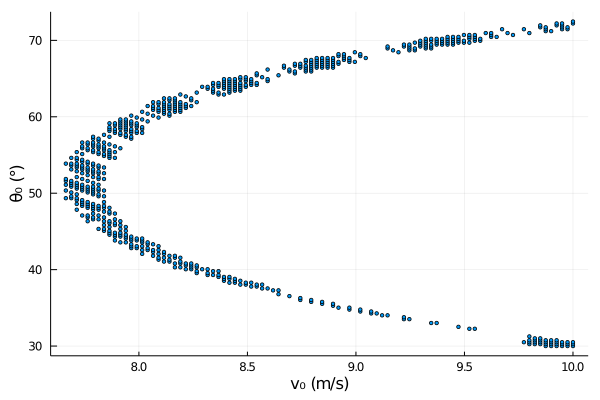

In [59]:
scatter(x, y, markersize=2, xlabel="v₀ (m/s)", ylabel="θ₀ (°)", label="")

In [154]:
function throws_simulation2(vₘᵢₙ, vₘₐₓ, ωₘᵢₙ, ωₘₐₓ, points, time, distance, x₀, players_height, rim_y, ε)
    
    good_v₀s = Array{Float64,1}()
    good_ω₀s = Array{Float64,1}()
    
    v₀s   = range(vₘᵢₙ, stop=vₘₐₓ, length=points)
    ω₀s   = range(ωₘᵢₙ, stop=ωₘₐₓ, length=100)
    tspan = range(0,   stop=time, length=time*60)
    
    for ω₀ in ω₀s
        for v₀ in v₀s 
            global ω = ω₀
            u₀ = [x₀; v₀ * cos(π/4); players_height; v₀ * sin(π/4)]
            sol = rungekutta4(basketball_throw, u₀, tspan)
            y_index = findnearest(sol[:, 3], rim_y)[2]
            if scored(sol[y_index, 1], distance, ε)
                push!(good_v₀s, v₀)
                push!(good_ω₀s, ω₀)
            end
        end
    end
    return good_v₀s, good_ω₀s
end

throws_simulation2 (generic function with 1 method)

In [155]:
x, y = throws_simulation2(6, 9, 0, 20, 2000, 2, free_throw_line_x, 0, 1.8, rim_y, score_error)

([7.538269134567283, 7.539769884942471, 7.541270635317659, 7.542771385692847, 7.544272136068034, 7.545772886443221, 7.547273636818409, 7.548774387193597, 7.550275137568784, 7.551775887943972  …  7.452726363181591, 7.4842421210605306, 7.4857428714357175, 7.487243621810905, 7.488744372186093, 7.490245122561281, 7.491745872936468, 7.493246623311656, 7.4947473736868435, 7.496248124062031], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0])

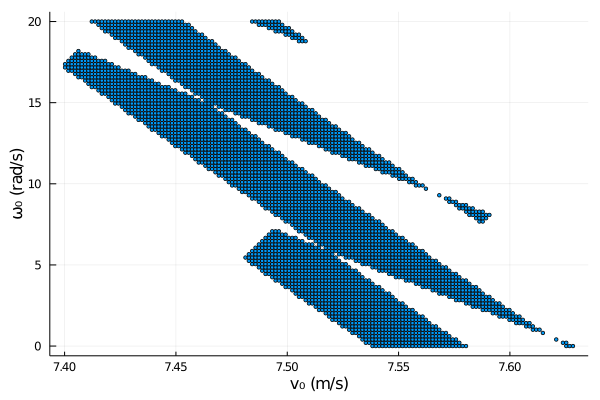

In [162]:
scatter(x, y, markersize=2, xlabel="v₀ (m/s)", ylabel="ω₀ (rad/s)", label="")